This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week10` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 10.3. Social Media.

In [88]:
%matplotlib inline
import json
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_false
from numpy.testing import assert_array_equal, assert_array_almost_equal

In this problem, we will construct a graph of the friends of Kevin Bacon's friends, because no study of social networks is complete without studying the [Six Degrees of Kevin Bacon](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon). Kevin Bacon (Twitter handle: `kevinbacon`, ID number: 348785149) has 203 Twitter friends as of March 27, 2016. Looking up friends of all 203 friends will take a long time due to Twitter's [rate limit](https://dev.twitter.com/rest/public/rate-limiting), so I let the following script run overnight and saved the results in a JSON file.

```python
import os
import tweepy as tw
from time import sleep

# Order: Access Token, Access Token Secret, 
# Consumer Key, Consumer SecretAccess
cred_file = '/home/data_scientist/Week8/notebooks/twitter.cred'

tokens = []

with open(cred_file, 'r') as fin:
    for line in fin:
        if line[0] != '#': # Not a comment line
            tokens.append(line.rstrip('\n'))

auth = tw.OAuthHandler(tokens[2], tokens[3])
auth.set_access_token(tokens[0], tokens[1])

api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

user_name = 'kevinbacon'

# We will save data as JSON, but JSON requries dictionary keys to be strings,
# so we will convert the IDs to strings.
user_id = str(api.get_user(user_name).id)

if os.path.exists('ids2ids.json'):
    with open('ids2ids.json') as f:
        ids2ids = json.load(f)
else:
    ids2ids = {user_id: [str(f) for f in api.friends_ids(id=user_id)]}


for friend in tw.Cursor(api.friends, id=user_id).items():
    
    screen_name = friend.screen_name
    
    # friend_id will be the keys, which must be strings.
    friend_id = str(friend.id)

    if friend_id in ids2ids:
        print('{0} alraedy exists.'.format(screen_name))
        continue

    print('Finding friends for {0}'.format(screen_name))
    
    try:
        fof = api.friends_ids(id=friend_id)
    except tw.error.TweepError:
        fof = []

    ids2ids[friend_id] = [str(f) for f in fof]
    
    print('Found {0} friends.'.format(len(ids2ids[friend_id])))

    with open('ids2ids.json', 'w') as f:
        json.dump(ids2ids, f)

    sleep(60) # necessary due to the rate limit
```

Start by loading the JSON file.

In [89]:
with open('/home/data_scientist/data/misc/ids2ids.json') as f:
    ids2ids = json.load(f)

The dictionary also has Kevin Bacon's freinds.

In [90]:
assert_true('348785149' in ids2ids)

As mentioned previously, Kevin Bacon has 203 friends, so we should have 204 keys (203 friends plus Kevin Bacon himself).

In [91]:
assert_equal(len(ids2ids), 204)

Note that both keys and values are strings.

In [92]:
assert_true(all(type(key) is str for key in ids2ids))
assert_true(all(type(value) is str for key in ids2ids for value in ids2ids[key]))

## Graph

- Create a directed graph, and add a node for the initial user (`'348785149'`).
- Next, step through the IDs of the user's friends.
- Inside this loop, step through the friend of friend ids for the current friend to identify any associations back to the original list of friends.
- If a match is found, add an edge to the graph as appropriate.

In [93]:
def create_digraph(ids2ids, start_node='348785149'):
    '''
    Creates a graph of friends of friends for the initial user 'start_node'.
    
    Paramters
    ---------
    ids2ids: A dictionary.
    
    Returns
    -------
    A networkx.DiGraph instance.
    '''
    
    #initialize direct graph and add initial Kevin Bacon node
    dg = nx.DiGraph()
    dg.add_node(start_node)
    
    friendsOfKB = ids2ids
    
    edgs = []
    
    #step through friends and then loop through friends of friends to find associations
    for friend in friendsOfKB:
        for fof in ids2ids[friend]:
            if fof in friendsOfKB:
                edgs.append((friend, fof))

    dg.add_edges_from(edgs) #add edges for each association

    return dg

In [94]:
dg = create_digraph(ids2ids)

In [95]:
assert_is_instance(dg, nx.DiGraph)
assert_equal(len(dg.nodes()), len(ids2ids))
assert_equal(set(dg.nodes()), set(ids2ids.keys()))
assert_equal(len(dg.edges()), 3648)
for start, end in dg.edges():
    assert_true(start in ids2ids)
    assert_true(end in ids2ids)

## Draw

- First, use `networkx.draw_networkx_nodes()` to draw the nodes.
- Then, use `networkx.draw_networkx_edges()` to draw the edges.
- Do not draw the labels (because we only have IDs and labels will only clutter the graph).

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week10/assignments/images/kevin_bacon.png)

Note that I chose not to draw the arrows here to avoid cluttering our graph.

In [96]:
def draw_social_graph(graph):
    '''
    Draws the "graph".
    
    Paramters
    ---------
    graph: A networkx.DiGraph instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    #initialize figure
    fig, ax = plt.subplots(figsize=(12,12)) 
    
    #make some plot tweaks
    sns.set(style="white", font_scale=1.0)
    clrs = sns.color_palette("Paired")    
    sns.despine(top = True, bottom = True, 
                left = True, right = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    #set layout positions
    pos = nx.spring_layout(graph)

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, with_labels=False,
                           node_size = 200,
                           node_color=clrs[0],
                           node_shape='H',
                           alpha = 0.4)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos,
                           width = 0.01,
                           edge_color=clrs.as_hex()[4],
                           alpha = 0.6)
    
    return ax

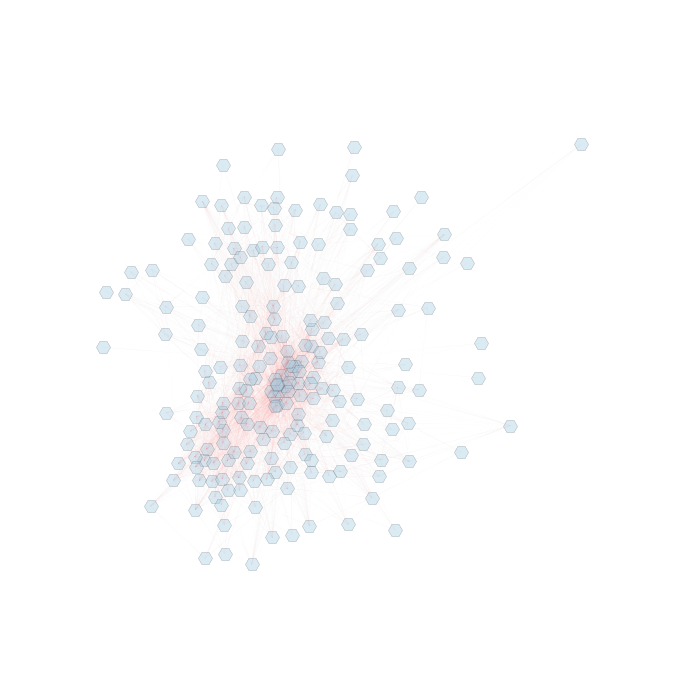

In [97]:
ax = draw_social_graph(dg)

In [98]:
assert_is_instance(ax, mpl.axes.Axes)
assert_equal(ax.collections[0].get_offsets().shape[0], len(dg.nodes()))
assert_equal(len(ax.collections[1].get_segments()), len(dg.edges()))